In [95]:
import tqdm
import random
import pathlib
import itertools
import collections

import cv2
import einops
import numpy as np
import remotezip as rz
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from tensorflow.keras import datasets, layers, models
from keras import layers

import os

1. Output not through sigmoid/softmax
- no transform
- softplus
2. Loss Function
- Not classification, cross entropy loss function
- mean squared error loss instead

In [96]:
regression_data =  [43, 52, 63, 59, 75, 66, 62, 70, 80, 102]
data = "C:/Users/elika/Senior Design/Data/FeCl3-Videos-2_21_25/"

In [97]:
#take the directory of videos and splits them into training, validation, and test sets
#Args: 
#    directory: the directory of videos
#    regression_data: the regression data for each video
#    splits: Dictionary specifying the training, validation, test, etc.
#Return:
#    Mapping of the directories containing the subsections of data.
#    Mapping of the regression data for each video.

def split_videos(directory, regression_data, splits):
    #get the list of videos
    videos = os.listdir(directory)
    #shuffle the videos
    random.shuffle(videos)
    #create a dictionary to hold the splits
    split_dict = {}
    #create a dictionary to hold the regression data
    regression_dict = {}
    #create a counter to keep track of the current split
    counter = 0
    #loop through the splits
    for split in splits:
        #get the number of videos for the current split
        num_videos = splits[split]
        #get the videos for the current split
        split_videos = videos[counter:counter+num_videos]
        #add the videos to the dictionary
        split_dict[split] = split_videos
        #get the regression data for the current split
        split_regression_data = regression_data[counter:counter+num_videos]
        #add the regression data to the dictionary
        regression_dict[split] = split_regression_data
        #increment the counter
        counter += num_videos

    #return the dictionaries
    return split_dict, regression_dict


In [98]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  if frame is None:
        print("Error: Received a None frame in format_frames")
        return None
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

In [127]:
def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  
  if not src.isOpened():
        print(f"Error: Could not open video file {video_path}")
        return None

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)
  #print(f"Video length of {video_path}: {video_length} frames")

  need_length = 1 + (n_frames - 1) * frame_step
  #print(f"Need length: {need_length} frames")

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)
  #print(f"Starting frame: {start}")

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  if not ret:
    print(f"Error: Could not read frame from video file {video_path}")
    return None
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      print(f"Error: Could not read frame from video file {video_path}")
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

In [128]:
class FrameGenerator:
  def __init__(self, path, regression_splits, n_frames, training = False):
    """ Returns a set of frames with their associated label. 

      Args:
        path: Video file paths.
        n_frames: Number of frames. 
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.regression = regression_splits
    #self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    #self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files(self):
    video_paths = self.path
    #print(f"Found {len(video_paths)} video files in {self.path}")
    return video_paths

  def __call__(self):
    video_paths = self.get_files()
    pairs = list(zip(video_paths, self.regression))

    if self.training:
      random.shuffle(pairs)

    for path, regression_value in pairs:
      if path.suffix not in ['.mp4', '.avi', '.mov']:  # Add other supported video formats if needed
        print(f"Skipping non-video file: {path}")
        continue
      #print(f"Processing video file: {path.resolve()}")
      video_frames = frames_from_video_file(path, self.n_frames) 
      if video_frames is not None:
        yield video_frames, regression_value
      else:
        print(f"Failed to extract frames from {path}")

In [130]:
HEIGHT = 224
WIDTH = 224

In [129]:
class ResizeVideo(keras.layers.Layer):
  def __init__(self, height, width):
    super().__init__()
    self.height = height
    self.width = width
    self.resizing_layer = layers.Resizing(self.height, self.width)

  def call(self, video):
    """
      Use the einops library to resize the tensor.  

      Args:
        video: Tensor representation of the video, in the form of a set of frames.

      Return:
        A downsampled size of the video according to the new height and width it should be resized to.
    """
    # b stands for batch size, t stands for time, h stands for height, 
    # w stands for width, and c stands for the number of channels.
    old_shape = einops.parse_shape(video, 'b t h w c')
    images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
    images = self.resizing_layer(images)
    videos = einops.rearrange(
        images, '(b t) h w c -> b t h w c',
        t = old_shape['t'])
    return videos

In [163]:
class PrintLayer(layers.Layer):
    def call(self, inputs):
        print(f"Shape of data before Flatten layer: {inputs.shape}")
        return inputs

In [131]:
data = "C:/Users/elika/Senior Design/Data/FeCl3-Videos-2_21_25/"

subset_paths, regression_splits = split_videos(  
                        directory = data,
                        regression_data = regression_data,
                        splits = {"train": 6, "val": 2, "test": 2})

In [132]:
n_frames = 10
batch_size = 8

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

base_dir = pathlib.Path(data)

#convert subset paths to pathlib objects
#subset_paths = {key: pathlib.Path(value) for key, value in subset_paths.items()}
subset_paths = {key: [base_dir / pathlib.Path(p).name for p in value] for key, value in subset_paths.items()}

train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], regression_splits['train'], n_frames, training=True),
                                          output_signature = output_signature)


# Batch the data
train_ds = train_ds.batch(batch_size)

val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], regression_splits['val'], n_frames),
                                        output_signature = output_signature)
val_ds = val_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], regression_splits['test'], n_frames),
                                         output_signature = output_signature)

test_ds = test_ds.batch(batch_size)

#print(f"Number of batches in train_ds: {len(list(train_ds))}")
#print(f"Number of batches in val_ds: {len(list(val_ds))}")
#print(f"Number of batches in test_ds: {len(list(test_ds))}")

In [160]:
# Check the shape of the elements in train_ds
for frames, label in train_ds.take(1):
    print(f"Shape of frames in train_ds: {frames.shape}")
    print(f"Shape of label in train_ds: {label.shape}")

# Check the shape of the elements in val_ds
for frames, label in val_ds.take(1):
    print(f"Shape of frames in val_ds: {frames.shape}")
    print(f"Shape of label in val_ds: {label.shape}")

Shape of frames in train_ds: (6, 10, 224, 224, 3)
Shape of label in train_ds: (6,)
Shape of frames in val_ds: (2, 10, 224, 224, 3)
Shape of label in val_ds: (2,)


In [ ]:
#resize the video
resize_video = ResizeVideo(HEIGHT, WIDTH)
frames = resize_video(frames)


In [176]:
model = models.Sequential()
model.add(layers.Input(shape=(n_frames, HEIGHT, WIDTH, 3)))
model.add(layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling3D((1, 2, 2)))
model.add(layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling3D((1, 2, 2)))
model.add(layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same'))

In [177]:
model.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_60 (Conv3D)              │ (None, 10, 224, 224,   │         2,624 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_40 (MaxPooling3D) │ (None, 10, 112, 112,   │             0 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_61 (Conv3D)              │ (None, 10, 112, 112,   │        55,360 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_41 (MaxPooling3D) │ (None, 10, 56, 56, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_62 (Conv3D)              │ (None, 10, 56, 56, 64) │       110,656 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 168,640 (658.75 KB)

 Trainable params: 168,640 (658.75 KB)

 Non-trainable params: 0 (0.00 B)

In [178]:
#model.add(PrintLayer())
model.add(layers.Reshape((10 * 56 * 56 * 64,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='softplus'))
model.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_60 (Conv3D)              │ (None, 10, 224, 224,   │         2,624 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_40 (MaxPooling3D) │ (None, 10, 112, 112,   │             0 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_61 (Conv3D)              │ (None, 10, 112, 112,   │        55,360 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_41 (MaxPooling3D) │ (None, 10, 56, 56, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_62 (Conv3D)              │ (None, 10, 56, 56, 64) │       110,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 2007040)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │   128,450,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,619,329 (490.64 MB)

 Trainable params: 128,619,329 (490.64 MB)

 Non-trainable params: 0 (0.00 B)

In [179]:
frames, label = next(iter(train_ds))
model.build(frames)

In [180]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mae'])

history = model.fit(x=train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50


      1/Unknown 10s 10s/step - loss: 3582.0750 - mae: 58.9762

C:\Users\elika\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - loss: 3582.0750 - mae: 58.9762 - val_loss: 1282.8724 - val_mae: 35.6232
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 1965.0142 - mae: 43.0570 - val_loss: 3208.5015 - val_mae: 56.5081
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 2624.8340 - mae: 50.2087 - val_loss: 3154.3672 - val_mae: 56.0324
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 2574.0168 - mae: 49.6955 - val_loss: 1879.4211 - val_mae: 43.1950
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 1503.5492 - mae: 37.3724 - val_loss: 122.7517 - val_mae: 10.1669
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 126.9724 - mae: 9.5774 - val_loss: 2173.5547 - val_mae: 46.5625
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 2683.5593 - mae: 50.4091 - val_loss: 72.8076 - val_mae: 8.0686
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 265.3566 - mae: 13.9476 - val_loss: 417.6046 - val_mae: 20.1817
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - 

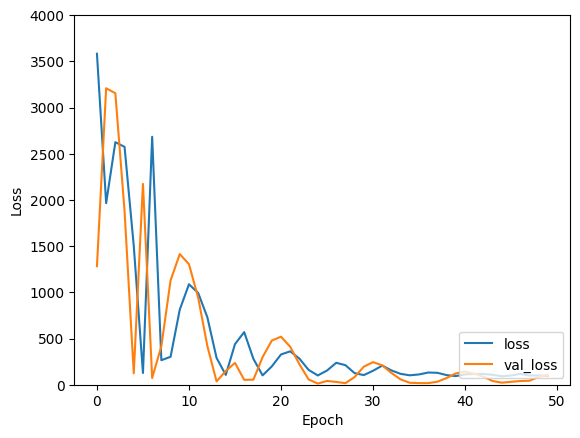

In [186]:
#plot the training and validation loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 4000])
plt.legend(loc='lower right')
plt.show()

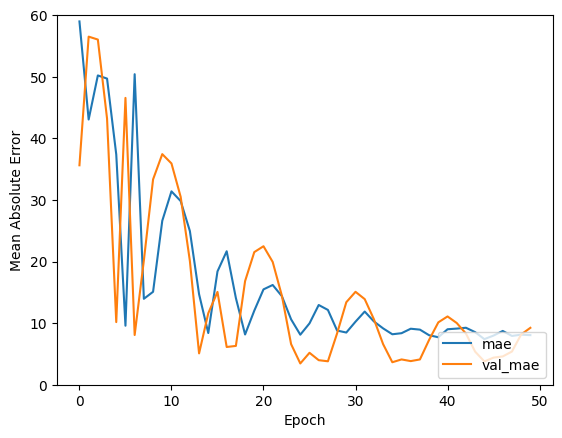

In [188]:
#plot the training and validation mae
plt.plot(history.history['mae'], label='mae')
plt.plot(history.history['val_mae'], label = 'val_mae')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.ylim([0, 60])
plt.legend(loc='lower right')
plt.show()


In [189]:
test_loss, test_mae = model.evaluate(test_ds, verbose=2)

1/1 - 2s - 2s/step - loss: 1337.7863 - mae: 35.0353


C:\Users\elika\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [191]:
print(test_loss, test_mae)

1337.7862548828125 35.035255432128906
